In [1]:
import numpy as np
import glob
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from utils import *

In [12]:
#locate the history files and read in the dataset
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
tape='h0'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
files=np.array(files)

In [16]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
def get_cluster(workers=30,project = 'P93300641'):

    cluster = PBSCluster(
        cores=1, # The number of cores you want
        memory='10GB', # Amount of memory
        processes=1, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        local_directory='$TMPDIR', # Use your local directory
        resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
        account=project, # Input your project ID here
        walltime='02:30:00', # Amount of wall time
    )
    
    # Scale up
    cluster.scale(workers)
    
    # Setup your client
    client = Client(cluster)
    return client

In [17]:
client=get_cluster()

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42199 instead
  warnings.warn(


In [143]:
def pp(ds):
    dvs=['TSA','RAIN','SNOW','Q2M','FSDS',
         'TLAI','TOTECOSYSC','TOTECOSYSN','TOTSOILICE','TOTSOILLIQ','FSNO',
         'GPP','HR','AR','NBP','QRUNOFF','FSH','EFLX_LH_TOT']
    return ds[dvs]

In [144]:
def normx(x):
    x1,x2=x.quantile([0.02,0.98])
    return ((x-x1)/(x2-x1)).compute()

In [146]:
das=[]
for yr0 in range(1864,2014,30):
    print(yr0)
    ix=(yrs>yr0)&(yrs<=yr0+30)
    fset=files[ix]
    ds=xr.open_mfdataset(fset,combine='by_coords',parallel=True,preprocess=pp)
    for v in ds.data_vars:
        da=normx(ds[v].mean(dim='time'))
        das.append(da)
        da=normx(ds[v].std(dim='time'))
        das.append(da)

1864
1894
1924
1954
1984


In [147]:
mfg=xr.concat(das,dim='metric')
msg=mfg.stack({'gc':['lat','lon']}).isel(gc=ixsg)

In [149]:
sgmap=((mfg-msg)**2).sum(dim='metric').argmin(dim='gridcell')
sgmap.name='cluster'

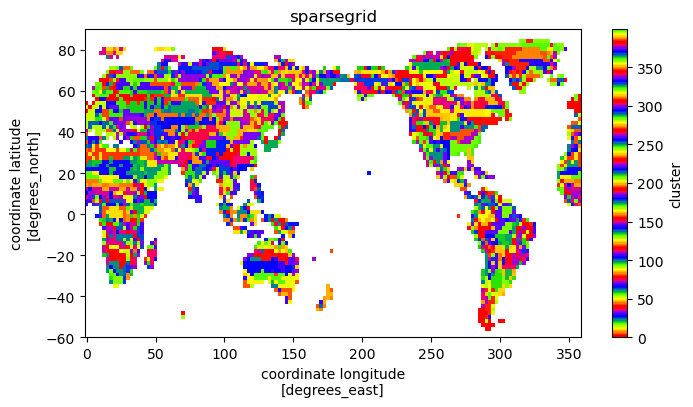

In [150]:
plt.figure(figsize=[8,4])
sgmap.where(tmp.landfrac>0).where(sgmap.lat>-60).plot(cmap='prism');
plt.ylim([-60,90])
plt.title('sparsegrid');

In [181]:
tmp=xr.open_dataset(fset[0])
dsout=xr.Dataset()
dsout['cclass']=sgmap
dsout['notnan']=(tmp.landfrac>0)&(tmp.lat>-60)
dsout.to_netcdf('sgmap_retrain_h0.nc')

In [189]:
la=tmp.area*tmp.landfrac*dsout.notnan
sgmap.name='gridcell'
lasg=la.groupby(sgmap).sum()
dsout2=xr.Dataset({'landarea':lasg})

In [191]:
dsout2.to_netcdf('landarea_retrain_h0.nc')

In [84]:
#sparsegrid subsetting
d='/glade/derecho/scratch/linnia/ctsm5.3.0_transient_oaat0057/run/'
f=d+'ctsm5.3.0_transient_oaat0057.clm2.h0.1850-02-01-00000.nc'
sg=xr.open_dataset(f)
nlat=len(sg.lat)
nlon=len(sg.lon)
m=mfg.stack({'gc':['lat','lon']})
ixsg=((sg.grid1d_jxy-1)*nlon+sg.grid1d_ixy-1).astype(int)